<a href="https://colab.research.google.com/github/dnjhaha/AML/blob/master/AMLASSIGN5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Danni Jin AML Spring 2020 assignment #5
**Set up First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:**

In [0]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
# Common imports
import numpy as np
import os
# to make this notebook's output stable across runs
np.random.seed(42)
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

**The first thing we'll need to do is load in the libraries we'll be using.**

In [0]:
#Loading libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from numpy import mean
from sklearn.svm import LinearSVC

**We have to read in the CSV file that is from the github. We'll use a package called pandas for that. Take a first look at the data.**

In [0]:
#loading Dataset
url = 'https://raw.githubusercontent.com/dnjhaha/AML/master/datasets/diabetic_data.csv'
diabetic = pd.read_csv(url)
diabetic.head(10)#displaying first 10 rows of data

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,?,?,31,6,16,0,0,0,414,411,250,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30
6,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,70,1,21,0,0,0,414,411,V45,7,None,None,Steady,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
7,63768,114882984,Caucasian,Male,[70-80),?,1,1,7,5,?,?,73,0,12,0,0,0,428,492,250,8,None,None,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,>30
8,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,68,2,28,0,0,0,398,427,38,8,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
9,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,33,3,18,0,0,0,434,198,486,8,None,None,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [0]:
#Checking data types of each variable
diabetic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

The first thing I do when I get a new dataset is take a look at some of it. This lets me see that it all read in correctly and get an idea of what's going on with the data.

In [0]:
#checking shape of the dataset
diabetic.shape

(101766, 50)

In [0]:
#Checking for missing values in dataset
#In the dataset missing values are represented as '?' sign
for col in diabetic.columns:
    if diabetic[col].dtype == object:
         print(col,diabetic[col][diabetic[col] == '?'].count())
        
print('gender', diabetic['gender'][diabetic['gender'] == 'Unknown/Invalid'].count()) # gender was coded differently so we use a custom count for this one          

race 2273
gender 0
age 0
weight 98569
payer_code 40256
medical_specialty 49949
diag_1 21
diag_2 358
diag_3 1423
max_glu_serum 0
A1Cresult 0
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
pioglitazone 0
rosiglitazone 0
acarbose 0
miglitol 0
troglitazone 0
tolazamide 0
examide 0
citoglipton 0
insulin 0
glyburide-metformin 0
glipizide-metformin 0
glimepiride-pioglitazone 0
metformin-rosiglitazone 0
metformin-pioglitazone 0
change 0
diabetesMed 0
readmitted 0
gender 3


# Perform data scrubbing (handle missing data, normalization, scaling, etc.)
Variable weight contains approximate 98% of the missing values so there is no significance in filling those missing values so we decided to drop these variables. Variable Payer code and medical specialty contains approximate 40% missing values so we also dropped these variables. Variables race, diag_1, diag_2, diag_3 and gender contains very less missing values as compared to other attributes which we dropped so for these attributes we also decided to drop those where missing values contains.

In [0]:
#dropping columns with large number of missing values
diabetic = diabetic.drop(['weight','payer_code','medical_specialty'], axis = 1)

In [0]:
drop_Idx = set(diabetic[(diabetic['diag_1'] == '?') & (diabetic['diag_2'] == '?') & (diabetic['diag_3'] == '?')].index)

drop_Idx = drop_Idx.union(set(diabetic['diag_1'][diabetic['diag_1'] == '?'].index))
drop_Idx = drop_Idx.union(set(diabetic['diag_2'][diabetic['diag_2'] == '?'].index))
drop_Idx = drop_Idx.union(set(diabetic['diag_3'][diabetic['diag_3'] == '?'].index))
drop_Idx = drop_Idx.union(set(diabetic['race'][diabetic['race'] == '?'].index))
#drop_Idx = drop_Idx.union(set(diabetic[diabetic['discharge_disposition_id'] == 11].index))
drop_Idx = drop_Idx.union(set(diabetic['gender'][diabetic['gender'] == 'Unknown/Invalid'].index))
new_Idx = list(set(diabetic.index) - set(drop_Idx))
diabetic = diabetic.iloc[new_Idx]

variables (drugs named citoglipton and examide), all records have the same value. So essentially these cannot provide any interpretive or discriminatory information for predicting readmission so we decided to drop these two variables

In [0]:
diabetic = diabetic.drop(['citoglipton', 'examide'], axis = 1)

In [0]:
#Checking for missing values in the data
for col in diabetic.columns:
    if diabetic[col].dtype == object:
         print(col,diabetic[col][diabetic[col] == '?'].count())
            
print('gender', diabetic['gender'][diabetic['gender'] == 'Unknown/Invalid'].count())   

race 0
gender 0
age 0
diag_1 0
diag_2 0
diag_3 0
max_glu_serum 0
A1Cresult 0
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
pioglitazone 0
rosiglitazone 0
acarbose 0
miglitol 0
troglitazone 0
tolazamide 0
insulin 0
glyburide-metformin 0
glipizide-metformin 0
glimepiride-pioglitazone 0
metformin-rosiglitazone 0
metformin-pioglitazone 0
change 0
diabetesMed 0
readmitted 0
gender 0


Let's take a look at the unique values for each column.

In [0]:
# for each column
for c in list(diabetic.columns):
    
    # get a list of unique values
    n = diabetic[c].unique()
    
    # if number of unique values is less than 30, print the values. Otherwise print the number of unique values
    if len(n)<30:
        print(c)
        print(n)
    else:
        print(c + ': ' +str(len(n)) + ' unique values')

encounter_id: 98052 unique values
patient_nbr: 68629 unique values
race
['Caucasian' 'AfricanAmerican' 'Other' 'Asian' 'Hispanic']
gender
['Female' 'Male']
age
['[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)' '[70-80)'
 '[80-90)' '[90-100)' '[0-10)']
admission_type_id
[1 2 3 6 4 5 8 7]
discharge_disposition_id
[ 1  3  6  2  5 11  7 25 10  4 14 18  8 13 12 16 17 22 23  9 20 15 24 28
 19 27]
admission_source_id
[ 7  2  4  1  5  6 20  3 17  8  9 14 10 22 11 25 13]
time_in_hospital
[ 3  2  1  4  5 13 12  9  7 10 11  6  8 14]
num_lab_procedures: 118 unique values
num_procedures
[0 5 1 6 2 3 4]
num_medications: 75 unique values
number_outpatient: 39 unique values
number_emergency: 33 unique values
number_inpatient
[ 0  1  2  3  6  5  4  7  8  9 15 10 11 14 12 13 16 21 18 19]
diag_1: 713 unique values
diag_2: 740 unique values
diag_3: 786 unique values
number_diagnoses
[ 9  6  7  5  8  3  4 16 12 13 15 10 11 14]
max_glu_serum
['None' '>300' 'Norm' '>200']
A1Cresult
['None' '>7' '>

From analysis of the columns, we can see there are a mix of categorical (non-numeric) and numerical data. A few things to point out,

- encounter_id and patient_nbr: these are just identifiers and not useful variables

- admission_type_id,discharge_disposition_id,admission_source_id: are numerical here, but are IDs (see IDs_mapping). They should be considered categorical. 

- diag1, diag2, diag3 - are categorical and have a lot of values. We will not use these as part of this project, but you could group these ICD codes to reduce the dimension. We will use number_diagnoses to capture some of this information. 



# Categorical Features
The next type of features we want to create are categorical variables. Categorical variables are non-numeric data such as race and gender. To turn these non-numerical data into variables, the simplest thing is to use a technique called one-hot encoding, which will be explained below.

The first set of categorical data we will deal with are these columns:

In [0]:
cols_cat = ['race', 'gender']


To convert our categorical features to numbers, we will use a technique called one-hot encoding. In one-hot encoding, you create a new column for each unique value in that column. Then the value of the column is 1 if the sample has that unique value or 0 otherwise. For example, for the column race, we would create new columns ('race_Caucasian','race_AfricanAmerican', etc). If the patient's race is Caucasian, the patient gets a 1 under 'race_Caucasian' and 0 under the rest of the race columns. To create these one-hot encoding columns, we can use the get_dummies function.

In [0]:
cols_cat_num = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']

diabetic[cols_cat_num] = diabetic[cols_cat_num].astype('str')

Now we are ready to make all of our categorical features

In [0]:
diabetic_cat = pd.get_dummies(diabetic[cols_cat + cols_cat_num ],drop_first = True)

In [0]:
diabetic_cat.head()

,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Male,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,discharge_disposition_id_10,discharge_disposition_id_11,discharge_disposition_id_12,discharge_disposition_id_13,discharge_disposition_id_14,discharge_disposition_id_15,discharge_disposition_id_16,discharge_disposition_id_17,discharge_disposition_id_18,discharge_disposition_id_19,discharge_disposition_id_2,discharge_disposition_id_20,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_24,discharge_disposition_id_25,discharge_disposition_id_27,discharge_disposition_id_28,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_8,discharge_disposition_id_9,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_17,admission_source_id_2,admission_source_id_20,admission_source_id_22,admission_source_id_25,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


To add the one-hot encoding columns to the dataframe we can use concat function. Make sure to use axis = 1 to indicate add the columns.

In [0]:
diabetic = pd.concat([diabetic,diabetic_cat], axis = 1)

Save the column names of the categorical data.

In [0]:
cols_all_cat = list(diabetic_cat.columns)

Number of medication changes: The dataset contains 23 features for 23 drugs (or combos) which indicate for each of these, whether a change in that medication was made or not during the current hospital stay of patient. Medication change for diabetics upon admission has been shown by previous research to be associated with lower readmission rates. We decided to count how many changes were made in total for each patient, and declared that a new feature. The reasoning here was to both simplify the model and possibly discover a relationship with number of changes regardless of which drug was changed.

In [0]:
keys = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone','metformin-rosiglitazone', 'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']
# keys is the same as before
for col in keys:
    diabetic[col] = diabetic[col].replace('No', 0)
    diabetic[col] = diabetic[col].replace('Steady', 1)
    diabetic[col] = diabetic[col].replace('Up', 2)
    diabetic[col] = diabetic[col].replace('Down', 3)

Encoding some variables: The original dataset used string values for gender, race, medication change, and each of the 23 drugs used. To better fit those variables into our model, we interpret the variables to numeric binary variables to reflect their nature. For example, we encoded the “ medication change ” feature from “No” (no change) and “Ch” (changed) into 0 and 1.

In [0]:
diabetic['change'] = diabetic['change'].replace('Ch', 1)
diabetic['change'] = diabetic['change'].replace('No', 0)
diabetic['diabetesMed'] = diabetic['diabetesMed'].replace('Yes', 1)
diabetic['diabetesMed'] = diabetic['diabetesMed'].replace('No', 0)


We also reduced both A1C test result and Glucose serum test result into categories of Normal, Abnormal and Not tested.

In [0]:
diabetic['A1Cresult'] = diabetic['A1Cresult'].replace('>7', 1)
diabetic['A1Cresult'] = diabetic['A1Cresult'].replace('>8', 1)
diabetic['A1Cresult'] = diabetic['A1Cresult'].replace('Norm', 0)
diabetic['A1Cresult'] = diabetic['A1Cresult'].replace('None', 2)
diabetic['max_glu_serum'] = diabetic['max_glu_serum'].replace('>200', 1)
diabetic['max_glu_serum'] = diabetic['max_glu_serum'].replace('>300', 1)
diabetic['max_glu_serum'] = diabetic['max_glu_serum'].replace('Norm', 0)
diabetic['max_glu_serum'] = diabetic['max_glu_serum'].replace('None', 2)

Dealing with age: There are different ways to deal with this. The dataset only gives us age as 10 year categories, so we don’t know the exact age of each patient. The previous study on this dataset used age categories as nominal variables, but we wanted to be able to see the effect of increasing age on readmission, even if in a crude way. To do that, we assume that age of the patient on average lies at the midpoint of the age category. For example, if the patient’s age category is 20–30 years, then we assume the age = 25 years. So we converted age categories to midpoints, resulting in a numeric variable:

In [0]:
# code age intervals [0-10) - [90-100) from 1-10
for i in range(0,10):
    diabetic['age'] = diabetic['age'].replace('['+str(10*i)+'-'+str(10*(i+1))+')', i+1)
diabetic['age'].value_counts()

8     25305
7     21809
9     16702
6     16697
5      9265
4      3548
10     2717
3      1478
2       466
1        65
Name: age, dtype: int64

In [0]:
diabetic['diag_1'] = diabetic['diag_1'].str.replace('V', '')
diabetic['diag_2'] = diabetic['diag_2'].str.replace('V', '')
diabetic['diag_3'] = diabetic['diag_3'].str.replace('V', '')
diabetic['diag_1'] = diabetic['diag_1'].str.replace('E', '')
diabetic['diag_2'] = diabetic['diag_2'].str.replace('E', '')
diabetic['diag_3'] = diabetic['diag_3'].str.replace('E', '')
diabetic['diag_1'] = diabetic['diag_1'].astype(float)
diabetic['diag_2'] = diabetic['diag_2'].astype(float)
diabetic['diag_3'] = diabetic['diag_3'].astype(float)

Collapsing of Multiple Encounters for same patient Some patients in the dataset had more than one encounter.We could not count them as independent encounters because that bias the results towards those patients who had multiple encounters. Thus we tried multiple techniques to collapse and consolidate multiple encounters for same patient such as:

Considering more than 2 readmissions across multiple encounters as readmission for collapsed record.
Considering average stay at hospital across multiple encounters.
Considering the percentage of the medication changes across multiple encounters
Considering the total number of the encounters to replace the encounter unique ID
Considering the combination of diagnoses across multiple encounters as a list However, taking the features such as “diagnosis”, for instance, we did not find it not meaningful to combine multiple categorical values into an array for building data model. We then considered first encounter and last encounter separately as possible representations of multiple encounters. However, last encounters gave extremely imbalanced data for readmissions (96/4 Readmissions vs No Readmissions) and thus, we decided to use first encounters of patients with multiple encounters. This resulted in dataset being reduced to about 70,000 encounters:

In [0]:
diabetic = diabetic.drop_duplicates(subset= ['patient_nbr'], keep = 'first')
diabetic.shape


(68629, 98)

Encoding the outcome variable: The outcome we are looking at is whether the patient gets readmitted to the hospital within 30 days or not. The variable actually has < 30, > 30 and No Readmission categories. To reduce our problem to a binary classification, we combined the readmission after 30 days and no readmission into a single category:

In [0]:
diabetic['readmitted'].value_counts()

NO     40879
>30    21624
<30     6126
Name: readmitted, dtype: int64

Now let's define an output variable for our binary classification. Here we will try to predict if a patient is likely to be re-admitted within 30 days of discharge.

In [0]:
diabetic['OUTPUT_LABEL'] = (diabetic.readmitted == '<30').astype('int')

Let's define a function to calculate the prevalence of population that is readmitted with 30 days.

In [0]:
def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))

print('Prevalence:%.3f'%calc_prevalence(diabetic['OUTPUT_LABEL'].values))

Prevalence:0.089



Around 9% of the population is rehospitalized. This represented an imbalanced classification problem so we will address that below

# Data Visualization
**Distribution of Readmission**
**Our target variable is imbalance. Number of readmitted patient are quite less as compared to Not readmitted**

Text(0.5, 1.0, 'Distrinution of Readmission')

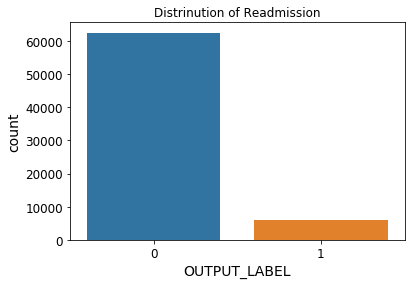

In [0]:
# Distribution of Readmission 
sns.countplot(diabetic['OUTPUT_LABEL']).set_title('Distrinution of Readmission')

Time in Hospital and Readmission

Text(0.5, 1.0, 'Time in Hospital VS. Readmission')

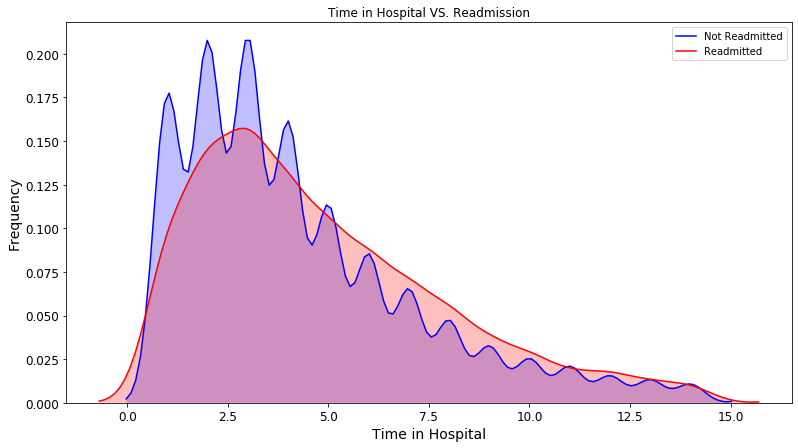

In [0]:
fig = plt.figure(figsize=(13,7),)
ax=sns.kdeplot(diabetic.loc[(diabetic['OUTPUT_LABEL'] == 0),'time_in_hospital'] , color='b',shade=True,label='Not Readmitted')
ax=sns.kdeplot(diabetic.loc[(diabetic['OUTPUT_LABEL'] == 1),'time_in_hospital'] , color='r',shade=True, label='Readmitted')
ax.set(xlabel='Time in Hospital', ylabel='Frequency')
plt.title('Time in Hospital VS. Readmission')

Age and Readmission

Text(0.5, 1.0, 'Age of Patient VS. Readmission')

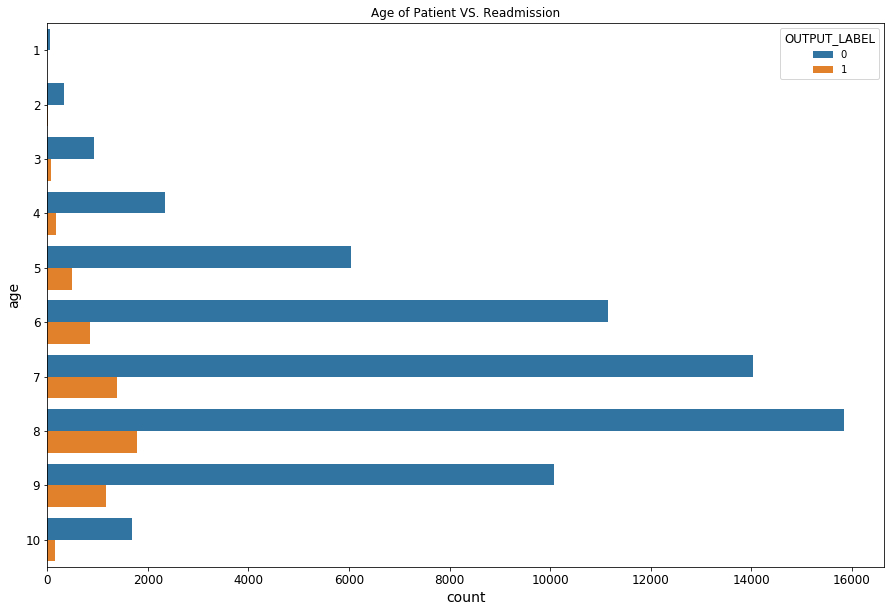

In [0]:
fig = plt.figure(figsize=(15,10))
sns.countplot(y= diabetic['age'], hue = diabetic['OUTPUT_LABEL']).set_title('Age of Patient VS. Readmission')

In [0]:
corr_matrix = diabetic.corr()
corr_matrix["OUTPUT_LABEL"].sort_values(ascending=False)

OUTPUT_LABEL                   1.000000
number_inpatient               0.099698
discharge_disposition_id_22    0.088348
discharge_disposition_id_3     0.057535
time_in_hospital               0.052030
                                 ...   
diag_1                        -0.015372
discharge_disposition_id_11   -0.039080
encounter_id                  -0.048829
glimepiride-pioglitazone            NaN
metformin-rosiglitazone             NaN
Name: OUTPUT_LABEL, Length: 93, dtype: float64

# model
We will utilize the following functions to evaluate the performance of the model.

In [0]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    #specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print(' ')
    return auc, accuracy, recall, precision


Since we balanced our training data, let's set our threshold at 0.5 to label a predicted sample as positive.

In [0]:
thresh = 0.5

In [0]:
feature = ['age', 'race_Asian',	'race_Caucasian',	'race_Hispanic','race_Other',	'gender_Male','admission_type_id_2','admission_type_id_3','admission_type_id_4','admission_type_id_5','admission_type_id_6','admission_type_id_7','admission_type_id_8','discharge_disposition_id_10','discharge_disposition_id_11','discharge_disposition_id_12','discharge_disposition_id_13','discharge_disposition_id_14','discharge_disposition_id_15','discharge_disposition_id_16','discharge_disposition_id_17','discharge_disposition_id_18','discharge_disposition_id_19','discharge_disposition_id_2','discharge_disposition_id_20','discharge_disposition_id_22','discharge_disposition_id_23','discharge_disposition_id_24','discharge_disposition_id_25','discharge_disposition_id_27','discharge_disposition_id_28','discharge_disposition_id_3','discharge_disposition_id_4','discharge_disposition_id_5','discharge_disposition_id_6','discharge_disposition_id_7','discharge_disposition_id_8','discharge_disposition_id_9','admission_source_id_10','admission_source_id_11','admission_source_id_13','admission_source_id_14','admission_source_id_17','admission_source_id_2','admission_source_id_20','admission_source_id_22','admission_source_id_25','admission_source_id_3','admission_source_id_4','admission_source_id_5',	'admission_source_id_6',	'admission_source_id_7',	'admission_source_id_8','admission_source_id_9','time_in_hospital', 'num_lab_procedures','num_procedures', 'num_medications', 'number_outpatient', 
                 'number_emergency', 'number_inpatient', 'number_diagnoses', 
                 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone','metformin-rosiglitazone', 'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide',
                  'max_glu_serum', 'A1Cresult', 'diag_1','diag_2','diag_3']

**Random Forest**

In [0]:
X = diabetic[feature]
y = diabetic['OUTPUT_LABEL']
all = pd.concat([X, y], axis=1) 
# shuffle the samples
all = all.sample(n = len(all), random_state = 42)
all = all.reset_index(drop = True)
# Save 30% of the data as validation and test data 
df_valid_test=all.sample(frac=0.30,random_state=42)
print('Split size: %.3f'%(len(df_valid_test)/len(all)))
df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)
#use the rest of the data as training data
df_train_all=all.drop(df_valid_test.index)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)


Split size: 0.300


In [0]:
# split the training data into positive and negative
rows_pos = all.OUTPUT_LABEL == 1
X_train_pos = all.loc[rows_pos]
X_train_neg =all.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([X_train_pos, X_train_neg.sample(n = len(X_train_pos), random_state = 42)],axis = 0)

# shuffle the order of training samples 
X_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

print('Train balanced prevalence(n = %d):%.3f'%(len(X_train), calc_prevalence(df_train.OUTPUT_LABEL.values)))

Train balanced prevalence(n = 12252):0.500


In [0]:
X_train = df_train[feature].values
X_train_all = df_train_all[feature].values
X_valid = df_valid[feature].values

y_train = df_train['OUTPUT_LABEL'].values
y_valid = df_valid['OUTPUT_LABEL'].values

print('Training All shapes:',X_train_all.shape)
print('Training shapes:',X_train.shape, y_train.shape)
print('Validation shapes:',X_valid.shape, y_valid.shape)

Training All shapes: (48040, 88)
Training shapes: (12252, 88) (12252,)
Validation shapes: (10295, 88) (10295,)


In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit_transform(X_train_all)
X_train_sc= scaler.fit_transform(X_train)
X_valid_sc= scaler.fit_transform(X_valid)

In [0]:
from sklearn import svm
clf=svm.LinearSVC(C=1,loss="hinge")
clf.fit(X_train_sc,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
          penalty='l2', random_state=None, tol=0.0001, verbose=0)

In [0]:
y_train_preds = clf._predict_proba_lr(X_train_sc)[:,1]
y_valid_preds = clf._predict_proba_lr(X_valid_sc)[:,1]

print('LinearSVC')
print('Training:')
sv_train_auc, sv_train_accuracy, sv_train_recall, sv_train_precision =print_report(y_train,y_train_preds, thresh)
print('Validation:')
sv_valid_auc, sv_valid_accuracy, sv_valid_recall, sv_valid_precision= print_report(y_valid,y_valid_preds, thresh)

LinearSVC
Training:
AUC:0.622
accuracy:0.598
recall:0.433
precision:0.646
 
Validation:
AUC:0.641
accuracy:0.699
recall:0.511
precision:0.145
 


In [0]:
from sklearn.linear_model import SGDClassifier
sgdc=SGDClassifier(loss = 'log',alpha = 0.1,random_state = 42)
sgdc.fit(X_train_sc, y_train)

SGDClassifier(alpha=0.1, average=False, class_weight=None, early_stopping=False,
              epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
              learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [0]:
y_train_preds = sgdc.predict_proba(X_train_sc)[:,1]
y_valid_preds = sgdc.predict_proba(X_valid_sc)[:,1]

print('Stochastic Gradient Descend')
print('Training:')
sgdc_train_auc, sgdc_train_accuracy, sgdc_train_recall, sgdc_train_precision =print_report(y_train,y_train_preds, thresh)
print('Validation:')
sgdc_valid_auc, sgdc_valid_accuracy, sgdc_valid_recall, sgdc_valid_precision = print_report(y_valid,y_valid_preds, thresh)

Stochastic Gradient Descend
Training:
AUC:0.658
accuracy:0.610
recall:0.540
precision:0.627
 
Validation:
AUC:0.658
accuracy:0.605
recall:0.606
precision:0.126
 


In [0]:
pol=SVC(kernel="poly", degree=10, coef0=100, C=5)
model_pol=pol.fit(X_train_sc,y_train)

In [0]:
from sklearn.ensemble import RandomForestClassifier
#rf = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = "gini", min_samples_split=10)
rf=RandomForestClassifier(max_depth = 6, random_state = 42)
model=rf.fit(X_train_sc, y_train)

In [0]:
y_train_preds = rf.predict_proba(X_train_sc)[:,1]
y_valid_preds = rf.predict_proba(X_valid_sc)[:,1]

print('Random Forest')
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision =print_report(y_train,y_train_preds, thresh)
print('Validation:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision= print_report(y_valid,y_valid_preds, thresh)

Random Forest
Training:
AUC:0.684
accuracy:0.626
recall:0.558
precision:0.646
 
Validation:
AUC:0.663
accuracy:0.655
recall:0.549
precision:0.133
 


# Feature Importance: random forest
We can also investigate feature importance for random forest models. In this case, the feature importance shows how often a particular feature was used to split the data. In this case, we don't know if a particular feature is correlated with the positive class or negative class, but rather it is just importance for making a decision.

In [0]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = feature,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances.head()                                    

,importance
number_inpatient,0.158744
discharge_disposition_id_22,0.109983
discharge_disposition_id_3,0.089603
time_in_hospital,0.078903
discharge_disposition_id_11,0.071552


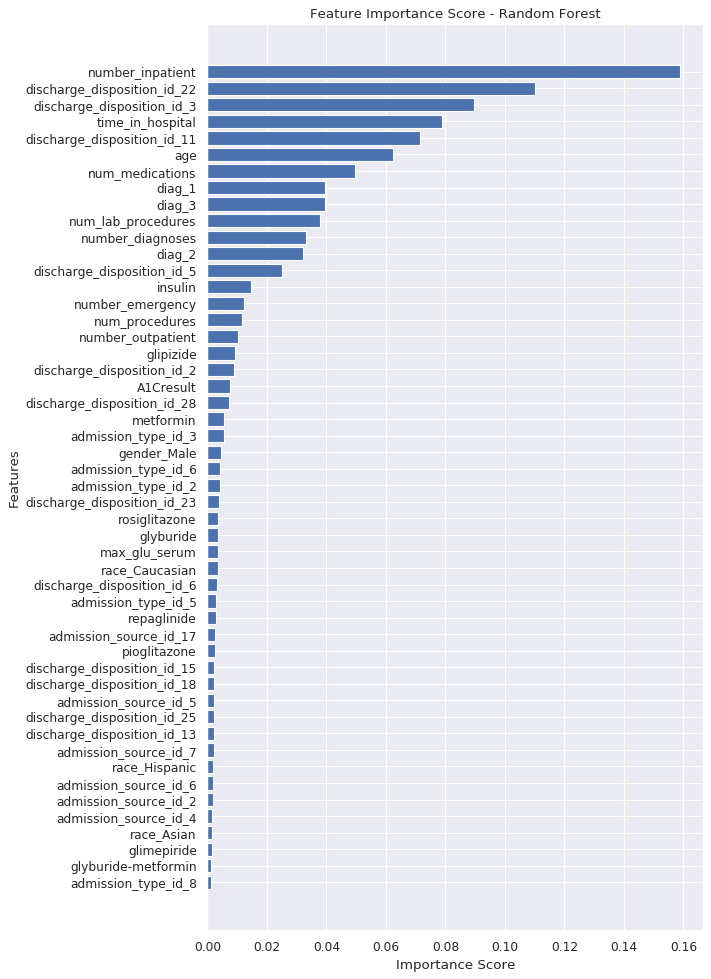

In [0]:
num = 50
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score - Random Forest')
plt.yticks(ylocs, feature_labels)
plt.show()

In [0]:
# Create list of top most features based on importance
feature_names = X_train_sc.columns
feature_imports = rf.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest ')
plt.show()

AttributeError: ignored

# Model Comparision

In [0]:
df_results = pd.DataFrame({'classifier':['linearsvc','linearsvc','SGD','SGD','RF','RF'],
                           'data_set':['train','valid']*3,
                          'auc':[sv_train_auc,sv_valid_auc,sgdc_train_auc,sgdc_valid_auc,rf_train_auc,rf_valid_auc],
                          'accuracy':[sv_train_accuracy,sv_valid_accuracy,sgdc_train_accuracy,sgdc_valid_accuracy,rf_train_accuracy,rf_valid_accuracy],
                          'recall':[sv_train_recall,sv_valid_recall,sgdc_train_recall,sgdc_valid_recall,rf_train_recall,rf_valid_recall],
                          'precision':[sv_train_precision,sv_valid_precision,sgdc_train_precision,sgdc_valid_precision,rf_train_precision,rf_valid_precision],
                          })

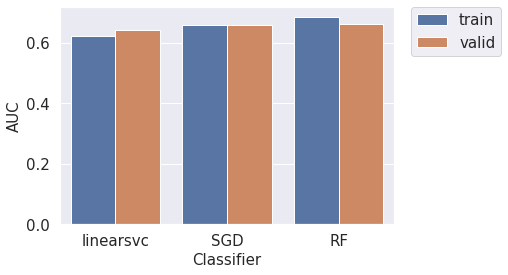

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
ax = sns.barplot(x="classifier", y="auc", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize=15)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)
plt.show()

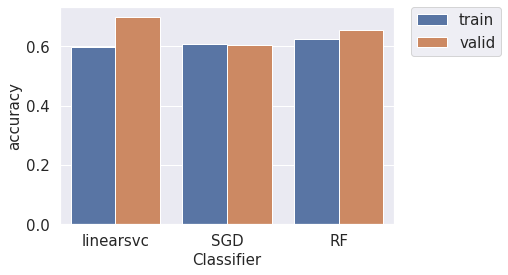

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
ax = sns.barplot(x="classifier", y="accuracy", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('accuracy', fontsize = 15)
ax.tick_params(labelsize=15)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)
plt.show()

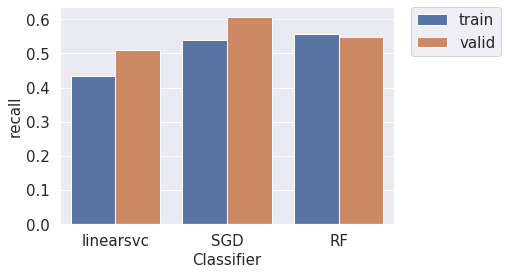

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
ax = sns.barplot(x="classifier", y="recall", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('recall', fontsize = 15)
ax.tick_params(labelsize=15)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)
plt.show()

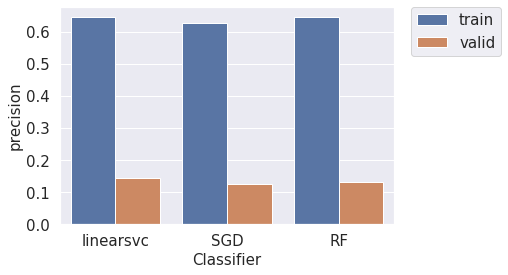

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
ax = sns.barplot(x="classifier", y="precision", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('precision', fontsize = 15)
ax.tick_params(labelsize=15)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)
plt.show()